* Multi-label classification using neural networks with a regularization
* Writer : Jesoon Kang, Chung-Ang University
* last-modified date : June 4, 2020

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import math
from IPython.display import display, Math, Latex
import os
import time
import datetime


# Opening data file

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

In [24]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.4 GB
Cached:    0.8 GB


In [3]:
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

In [4]:
#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

In [5]:
#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1


In [6]:
def sigmoid_grad(z):
    sig_value =  1.0 / (1.0 + np.exp(-z))
    return sig_value * (1 - sig_value)

# Return derivative of in
def sig_grad(z) :
    return z * (1-z)

In [8]:
#Function to getting running time
def get_running_time(start_time) :
    running_time = datetime.datetime.now() - start_time
    running_time = running_time.seconds
    hours, remainder = divmod(running_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

In [9]:

# Make image, label data to tensor type
train_image = list_image[:, :1000]
train_label = list_label[:1000]
test_image = list_image[:,1000:]
test_label = list_label[1000:]

train_label_vec = np.zeros((10, train_label.shape[0]))
test_label_vec = np.zeros((10, test_label.shape[0]))
for i, val in enumerate(train_label):
    train_label_vec[val, i] = 1.0
for i, val in enumerate(test_label):
    test_label_vec[val, i] = 1.0

    
train_input_with_bias = np.ones((train_image.shape[0]+1, train_image.shape[1])) # add bia
train_input_with_bias[1:, :] = train_image
test_input_with_bias = np.ones((test_image.shape[0]+1, test_image.shape[1])) # add bia
test_input_with_bias[1:, :] = test_image

In [10]:
# Make data to tensor
train_input_with_bias = torch.DoubleTensor(train_input_with_bias).to(device)
test_input_with_bias = torch.DoubleTensor(test_input_with_bias).to(device)
train_label_vec = torch.DoubleTensor(train_label_vec).to(device)
test_label_vec = torch.DoubleTensor(test_label_vec).to(device)
train_label = torch.DoubleTensor(train_label).to(device)
test_label = torch.DoubleTensor(test_label).to(device)

In [32]:
class ML :
    def __init__(self,layer_info = [196,49,10],lr = 1e-3,weight_decay= 1e-4,loss_conv = 1e-6,monitoring_epoch = 0) :
        print('-'*20,"ML START", '-'*20)
        
        
        print("lr : {}, weight_decay : {}, loss_conv : {}, thetas : {}".format(lr, weight_decay, loss_conv, layer_info))
        self.list_layer_info = layer_info
        self.init_thetas()
        
        # Get number of thetas(total)
        self.th_num = 0
        for th in self.list_theta :
            self.th_num += th.view(-1).shape[0]
        
        # Initial variable setting
        self.monitoring_epoch = monitoring_epoch
        self.num_hidden_layer = len(self.list_theta)-1
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_conv = loss_conv
        self.epoch = 0
        self.list_epoch = []
        self.list_loss_train = []
        self.list_loss_test = []
        self.list_acc_train = []
        self.list_acc_test = []
        self.list_y = []
        self.list_a = []
        self.result_train = {}
        self.result_test = {}
        self.start_time = datetime.datetime.now()
        self.exit_count = 0
        self.list_dL = []
        self.list_grad = []
        self.exit_count = 0
        self.train()

    # Get mean value of theta square
    def get_mean_theta_square(self,list_theta) :
        sum_th = 0
        th_num = 0
        for th in list_theta :
            sum_th += torch.sum(th**2)
            th_num += th.view(-1).shape[0]
        return sum_th/self.th_num
    
    # Initialize theta
    def init_thetas(self) :
        self.list_theta = []
        list_d = [784]
        for d in self.list_layer_info :
            th = torch.randn((d,list_d[-1]+1),dtype=torch.double).to(device)
            self.list_theta.append(th)
            list_d.append(d)
        
    # monitoring 
    def monitoring(self) :
        if self.monitoring_epoch != 0 :
            if self.epoch % self.monitoring_epoch == 0 :
                running_time = get_running_time(self.start_time)
                print("Train Acc : {:.3f}, Loss : {:.8f} | epoch : {}, time : {:02d}:{:02d}:{:02d}\nTest  Acc : {:.3f}, Loss : {:.8f}".\
                      format(self.list_acc_train[-1],self.list_loss_train[-1],self.epoch,running_time[0],running_time[1],running_time[2],self.list_acc_test[-1],self.list_loss_test[-1]))
        
    # Train.
    def train(self) :
        while (True) :
            self.forward_propagation_train()
            self.set_gradient_decent()
            self.forward_propagation_test()
            self.update_weights()
            self.monitoring()
            
            if self.check_terminate() :
                self.terminate()
                break
        

    # Check the loss gap
    def check_terminate(self) :
        if self.epoch > 5 :
            loss_gap = abs(self.list_loss_train[-1] - self.list_loss_train[-2])
            if loss_gap < self.loss_conv :
                self.exit_count += 1
            else :
                self.exit_count = 0
            if self.exit_count > 4 :
                return True
        return False
    
    # Terminate Train. Save example data
    def terminate(self) :
        # Save result.
        self.result_train["epoch"] = self.list_epoch
        self.result_train["loss"] = self.list_loss_train
        self.result_train["acc"] = self.list_acc_train
        self.result_train["theta"] = self.list_theta

        self.result_test["epoch"] = self.list_epoch
        self.result_test["loss"] = self.list_loss_test
        self.result_test["acc"] = self.list_acc_test

        # Save Sample images
        list_correct_image = []
        list_correct_label = []
        list_incorrect_image = []
        list_incorrect_label = []
        num_correct=0
        num_incorrect=0

        # Save correct images
        for i, correct in enumerate(test_label == self.predict_test) :
            if (correct) :
                if num_correct < 10 :
                    list_correct_image.append(test_image[:,i])
                    list_correct_label.append(int(test_label[i].item()))
                    num_correct += 1
            else :
                # Save incorrect images
                if num_incorrect < 10 :
                    list_incorrect_image.append(test_image[:,i])
                    list_incorrect_label.append(int(self.predict_test[i].item()))
                    num_incorrect += 1
            if num_correct >= 10 and num_incorrect >= 10 :
                break
        self.result_test["correct_image"] = list_correct_image
        self.result_test["correct_label"] = list_correct_label
        self.result_test["incorrect_image"] = list_incorrect_image
        self.result_test["incorrect_label"] = list_incorrect_label

        print("Loss is converged. epoch {}".format(self.epoch))
        print("Training Process Ended")
        return True
        
    # Forward propagation on train data
    def forward_propagation_train(self) :
        self.epoch += 1
        self.list_epoch.append(self.epoch)
        self.list_y = []
        self.list_a = []
        self.list_a_bias = [train_input_with_bias]
        for idx, th in enumerate(self.list_theta) :    
            y_tmp = torch.mm(th,self.list_a_bias[-1])
            self.list_y.append(y_tmp)
            a_tmp = 1 / (1 + torch.exp(-y_tmp))
            self.list_a.append(a_tmp)
            a_bias_tmp = torch.ones((a_tmp.shape[0] + 1, a_tmp.shape[1]), dtype=torch.double).to(device)
            a_bias_tmp[1:, :] = a_tmp
            self.list_a_bias.append(a_bias_tmp)
        self.list_a_bias.pop()
        
        h = self.list_a[-1]
        
        # Get Loss value with L2 regulazation
        loss_train = torch.sum(-train_label_vec * (torch.log(h)) - (1 - train_label_vec)* torch.log(1 - h)) / len(h.T) + self.weight_decay*0.5*self.get_mean_theta_square(self.list_theta)
        self.list_loss_train.append(loss_train)
        
        # Calculate Acc
        self.predict_train = torch.argmax(h, axis = 0)
        self.correct_train = torch.sum(train_label == self.predict_train, axis = 0)
        acc_train = self.correct_train.item()/train_label.shape[0]
        self.list_acc_train.append(acc_train)
        
    # Forward propagation in test data
    def forward_propagation_test(self) :
        
        self.list_y = []
        self.list_a = []
        self.list_a_bias = [test_input_with_bias]
        for idx, th in enumerate(self.list_theta) :
           
            y_tmp = torch.mm(th,self.list_a_bias[-1])
            self.list_y.append(y_tmp)
            a_tmp = 1 / (1 + torch.exp(-y_tmp))
            self.list_a.append(a_tmp)
            a_bias_tmp = torch.ones((a_tmp.shape[0] + 1, a_tmp.shape[1]), dtype=torch.double).to(device)
            a_bias_tmp[1:, :] = a_tmp
            self.list_a_bias.append(a_bias_tmp)
        self.list_a_bias.pop()
        
        h = self.list_a[-1]
        
        # Get Loss value with L2 regulazation
        loss_test = torch.sum(-test_label_vec * (torch.log(h)) - (1 - test_label_vec)* torch.log(1 - h)) / len(h.T) + self.weight_decay*0.5*self.get_mean_theta_square(self.list_theta)
        self.list_loss_test.append(loss_test)


        # Calculate Acc
        self.predict_test = torch.argmax(h, axis = 0)
        self.correct_test = torch.sum(test_label == self.predict_test, axis = 0)
        acc_test = self.correct_test.item()/test_label.shape[0]
        self.list_acc_test.append(acc_test)
        
    def set_gradient_decent (self) :
         # Back propagation
        self.list_dL = []
        self.list_grad = []
        
        self.list_dL.append(self.list_a[-1]-train_label_vec)
        grad = torch.mm(self.list_dL[-1],self.list_a_bias[-1].T) + self.weight_decay*0.5*self.list_theta[-1]#/self.th_num
        
        self.list_grad.append(torch.mm(self.list_dL[-1],self.list_a_bias[-1].T))
        idx = 0
        # Calculate gradient decent in order from back-end
        for i in range(0,self.num_hidden_layer) :
            idx += 1
            dL_dy = torch.mm(self.list_theta[-idx].T,self.list_dL[-1]) * sig_grad(self.list_a_bias[-idx])
            dL_dy = dL_dy[1:, :]
            self.list_dL.append(dL_dy)
           
            # Get gradient decent value 
            grad = torch.mm(dL_dy, self.list_a_bias[-(idx+1)].T)
            # Applying L2 Regulazation 
            grad_2 = self.weight_decay*self.list_theta[-(idx+1)]#/self.th_num
            grad = grad + grad_2
            self.list_grad.append(grad)
        self.list_grad.reverse()
        
        # Update weights 
    def update_weights(self) :
        for th, grad in zip(self.list_theta,self.list_grad) :
            th -= self.lr * (grad)
            
    def show_correct_example(self) :

        list_label = self.result_test["correct_label"]
        list_image = np.array(self.result_test["correct_image"]).T
        f1 = plt.figure(1)

        for i in range(10):
            label       = list_label[i]
            im_vector   = list_image[:, i]
            im_matrix   = im_vector.reshape((size_row, size_col))

            plt.subplot(2, 5, i+1)
            plt.title(label)
            plt.imshow(im_matrix, cmap='Greys', interpolation='None')

            frame   = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
        plt.show()    

    def show_incorrect_example(self) :

        list_label = self.result_test["incorrect_label"]
        list_image = np.array(self.result_test["incorrect_image"]).T
        f1 = plt.figure(1)

        for i in range(10):
            label       = list_label[i]
            im_vector   = list_image[:, i]
            im_matrix   = im_vector.reshape((size_row, size_col))

            plt.subplot(2, 5, i+1)
            plt.title(label)
            plt.imshow(im_matrix, cmap='Greys', interpolation='None')

            frame   = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
        plt.show()    
    def show_loss_curve(self) :
        plt.title("Loss curve")
        plot_1, = plt.plot(self.result_train["epoch"],self.result_train["loss"], color='b',linewidth=2,alpha=0.8)
        plot_2, = plt.plot(self.result_test["epoch"],self.result_test["loss"], color='r',linewidth=2,alpha=0.8)
        plt.legend([plot_1,plot_2],["Training","Testing"])

    def show_acc_curve(self) :
        plt.title("Accuracy curve")
        plot_1, = plt.plot(self.result_train["epoch"],self.result_train["acc"], color='b',linewidth=2,alpha=0.8)
        plot_2, = plt.plot(self.result_test["epoch"],self.result_test["acc"], color='r',linewidth=2,alpha=0.8)
        plt.legend([plot_1,plot_2],["Training","Testing"])

    def show_final_acc(self) :
        print("Final Training Acc : {:.3f}%\nFinal Testing Acc : {:.3f}%".format(self.result_train["acc"][-1]*100,self.result_test["acc"][-1]*100))

In [ ]:
ml = ML([196,49,10],lr= 1e-3,loss_conv = 1e-9,weight_decay=4e-1,monitoring_epoch=1000)

-------------------- ML START --------------------
lr : 0.001, weight_decay : 0.4, loss_conv : 1e-09, thetas : [196, 49, 10]
Train Acc : 1.000, Loss : 0.14168401 | epoch : 1000, time : 00:00:27
Test  Acc : 0.828, Loss : 1.29183736
Train Acc : 1.000, Loss : 0.06815068 | epoch : 2000, time : 00:00:54
Test  Acc : 0.860, Loss : 1.06009508
Train Acc : 1.000, Loss : 0.04110397 | epoch : 3000, time : 00:01:22
Test  Acc : 0.880, Loss : 0.91012177


# Plot the loss curve

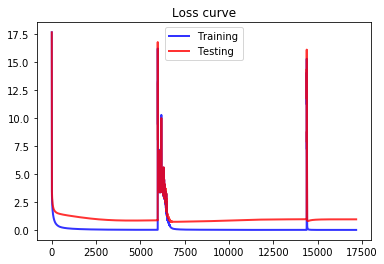

In [25]:
ml.show_loss_curve()

# Plot the accuracy curve

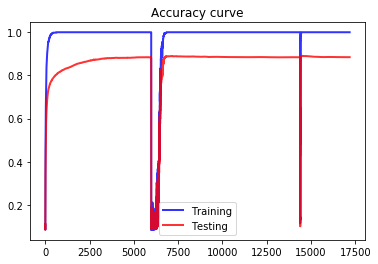

In [26]:
ml.show_acc_curve()

# Plot the accuracy value

In [27]:
ml.show_final_acc()

Final Training Acc : 100.000%
Final Testing Acc : 88.467%


# Plot the classification example

## Correctly classified testing images

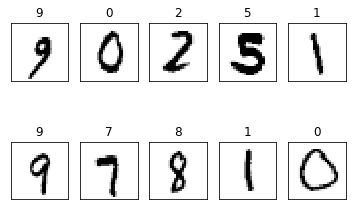

In [28]:
ml.show_correct_example()

## Misclassified testing images

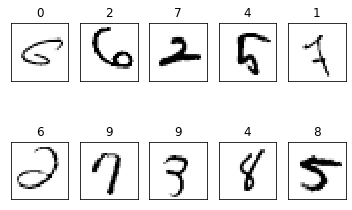

In [29]:
ml.show_incorrect_example()